In [1]:
# load pycodestyle-magic to be compliant with PEP8 conventions
%load_ext pycodestyle_magic

In [2]:
# activate pycodestyle for each cell
%pycodestyle_on

In [3]:
import sys
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [7]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
parameters = {'axes.labelsize': 16,
              'axes.titlesize': 20,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14}
plt.rcParams.update(parameters)

In [8]:
# Load training data
df = pd.read_csv('train.csv')

In [9]:
df.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
0,0,0,0,6,1,0,0,0,0,7,0,0,0,3,0,1,0,0,3,3,1,0,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,11,0,0,0,0,0,9,0,0,0,0,0,0,3,0,1,3,0,0,0,0,0,0,0,1,1,0,0,3,0,0,0,0,0,0,2,0,0,Class_6
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,Class_6
2,2,0,0,0,0,0,1,0,3,0,0,1,0,0,0,0,0,0,0,0,5,4,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,5,0,5,0,1,0,0,0,1,0,0,1,0,7,0,1,1,0,3,4,0,0,1,3,0,2,0,0,8,0,0,0,0,1,0,0,0,0,Class_2
3,3,0,0,7,0,1,5,2,2,0,1,2,0,5,0,0,4,0,0,22,2,1,0,0,0,0,3,0,37,0,1,3,13,0,10,0,3,1,1,0,7,0,0,2,0,1,0,0,0,0,0,0,10,0,0,25,1,0,1,2,0,2,0,7,0,0,0,0,4,0,2,2,0,4,3,0,Class_8
4,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_2


In [10]:
print('Dataset shape : ', df.shape)
print('Number of classes : ', df['target'].nunique())

Dataset shape :  (200000, 77)
Number of classes :  9


The training dataset contains 200000 products, caracterized by 75 features (positive integers). Each product belongs to one of the 9 classes (column `target`).

In [11]:
# initial size
sys.getsizeof(df)

134400144

In [12]:
df['target'] = df['target'].str[-1]
df = df.astype(np.int16)

In [13]:
all(df.dtypes == 'int16')

True

In [14]:
# final size
sys.getsizeof(df)

30800144

In [15]:
df.isnull().sum().sum()

0

No missing values, and all data in 16 bits integers. The dataset is clean!

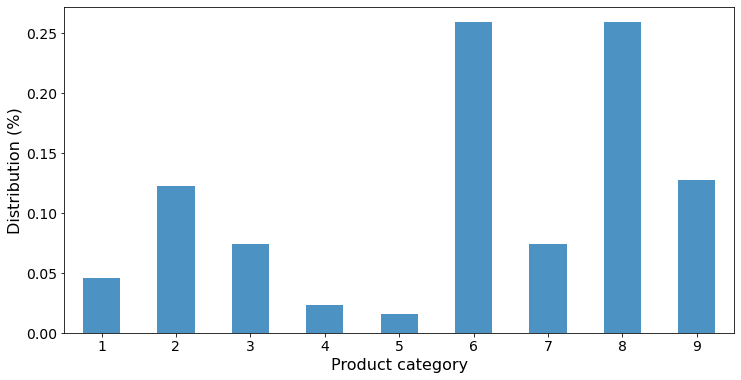

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
df['target'].value_counts(
    normalize=True)[[1, 2, 3, 4, 5, 6, 7, 8, 9]].plot.bar(
    alpha=0.8, rot=0, ax=ax)
ax.set_xlabel('Product category')
ax.set_ylabel('Distribution (%)')
plt.show()

All product categories are not uniformly represented in this dataset. We should take this into account in our `train_test_split`.

In [14]:
df.describe(include='all')

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000
mean,28.264160,0.972710,1.168365,2.219325,2.296735,0.793530,1.431105,1.010695,0.673090,1.94398,1.719655,1.422550,0.980955,2.444760,1.078085,1.406445,1.413200,1.389720,0.317740,1.656610,6.186895,1.438510,1.031415,1.465935,0.572000,1.061165,2.348775,0.774490,0.789325,2.326190,1.581820,0.598825,1.856545,1.516105,1.556650,0.681135,1.162070,0.665375,1.500505,1.276080,2.332940,1.255005,1.159385,0.834600,4.472965,0.890300,0.690865,2.413920,0.969055,1.527270,0.479560,2.275075,1.617085,0.622570,1.354225,6.008040,2.493365,2.118190,0.566695,0.927100,1.343715,1.666660,1.287270,2.764225,1.455190,0.696915,1.798040,0.508695,1.827300,0.910370,1.603585,1.219210,0.806895,1.282925,2.94021,0.632005,5.973705
std,18759.256337,3.941836,3.993407,6.476570,7.551858,2.935785,5.162746,3.949231,2.234949,3.93133,5.916988,3.288376,3.837771,3.421765,3.713650,2.868740,8.240441,3.056888,1.052619,2.557042,13.982531,2.666167,2.931762,6.734983,1.676326,5.718083,7.319992,1.752804,3.517043,8.402752,5.565404,1.418070,3.898896,7.782723,3.913513,2.307127,3.443417,2.637001,2.900480,4.268174,4.523171,4.482382,5.407836,3.496194,7.723795,2.150593,2.188692,9.774465,5.845938,4.375537,2.056233,5.227827,5.149637,1.953864,2.960980,11.286352,8.787684,4.107152,2.023164,2.697104,6.168400,6.387178,5.480586,8.251200,7.121127,2.185252,5.053014,1.867330,7.188924,3.835182,4.877679,4.826003,2.458741,4.261420,10.78465,3.925310,2.475353
min,-32768.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.

For most features, the distribution is mostly 0. The values can be as high as a few hundreds, but it is very rare. Thus, we have very skewed distributions for the features.

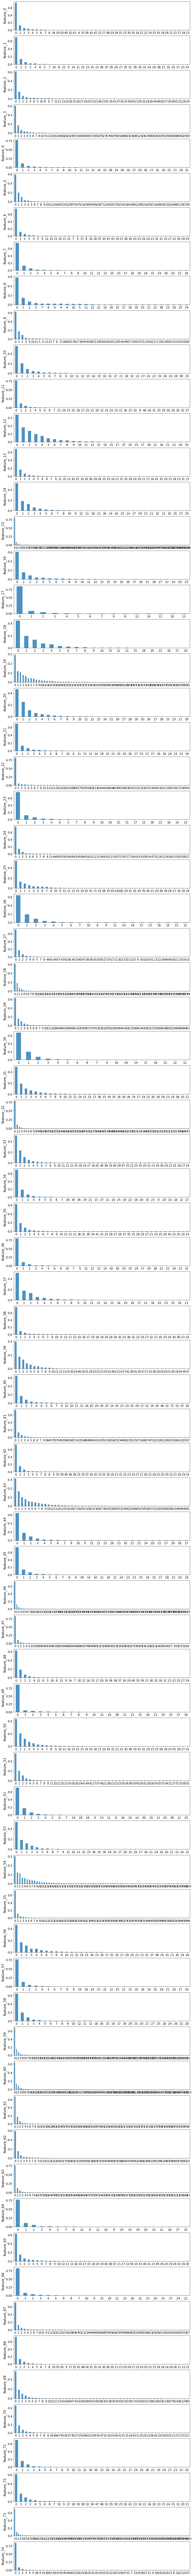

In [15]:
n = 75
fig, ax = plt.subplots(n, 1, figsize=(15, 3*n))
for i in range(n):
    df['feature_%d' % i].value_counts(
        normalize=True).plot.bar(
        alpha=0.8, rot=0, ax=ax[i])
    ax[i].set_ylabel('feature_%d' % i)
    if i == n:
        ax[i].set_xlabel('Values')

Let us check if there is any correlation between the features:

In [16]:
corr_matrix = df.corr()

In [17]:
# fill diagonal with 0 to obtain a better visual impression
np.fill_diagonal(corr_matrix.values, 0.)

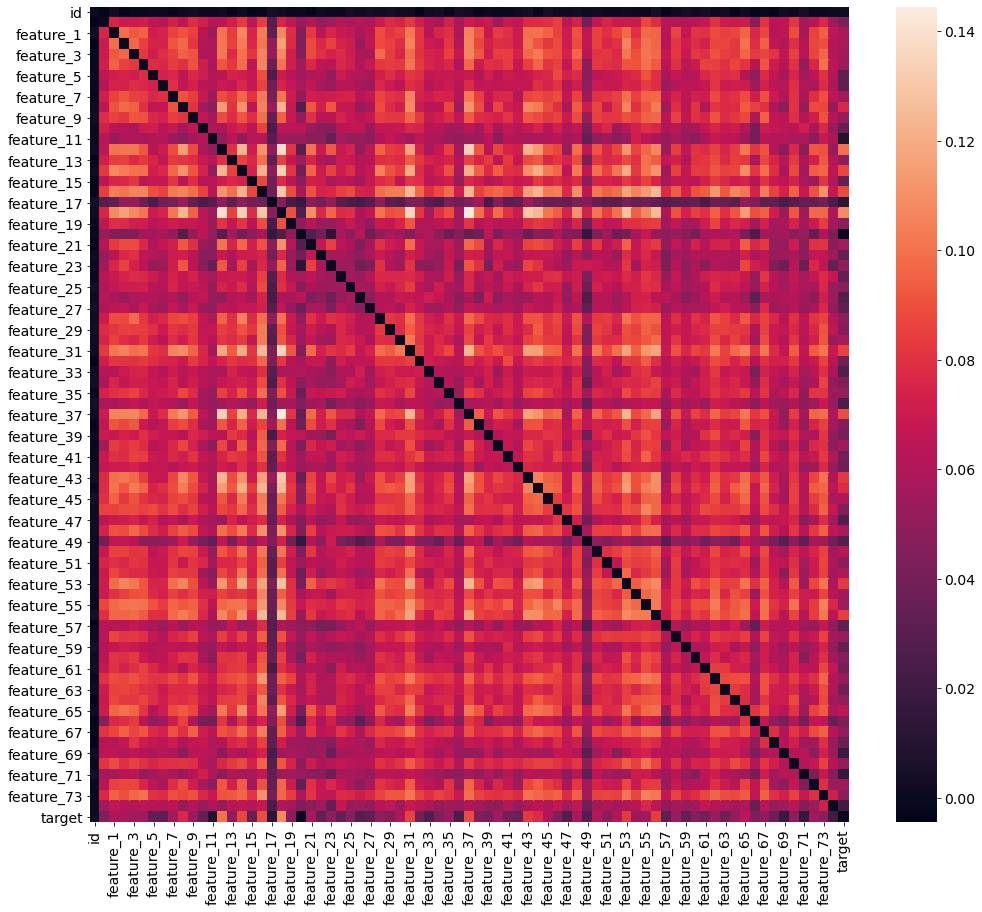

In [18]:
fig, ax = plt.subplots(figsize=(17, 15))
sns.heatmap(corr_matrix)
plt.show()

Nothing particularly obvious on the correlations between features. We can try to find correlations between features for each class in the dataset:

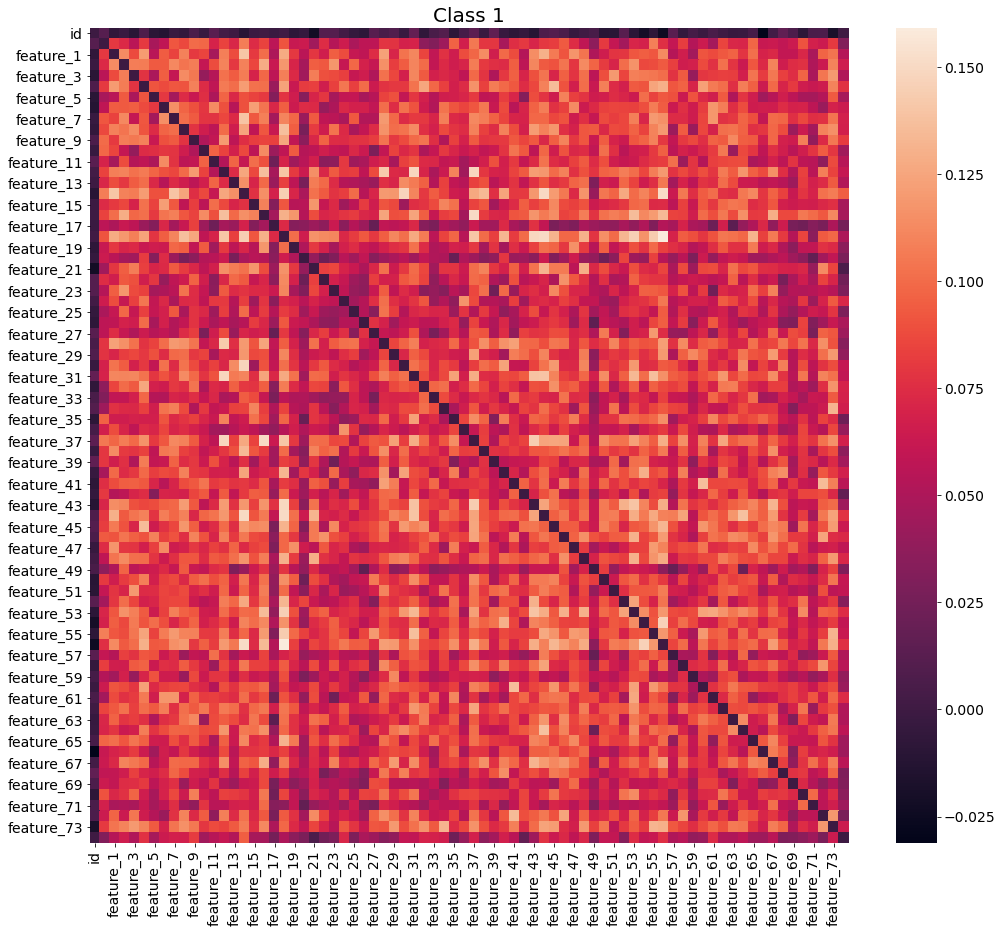

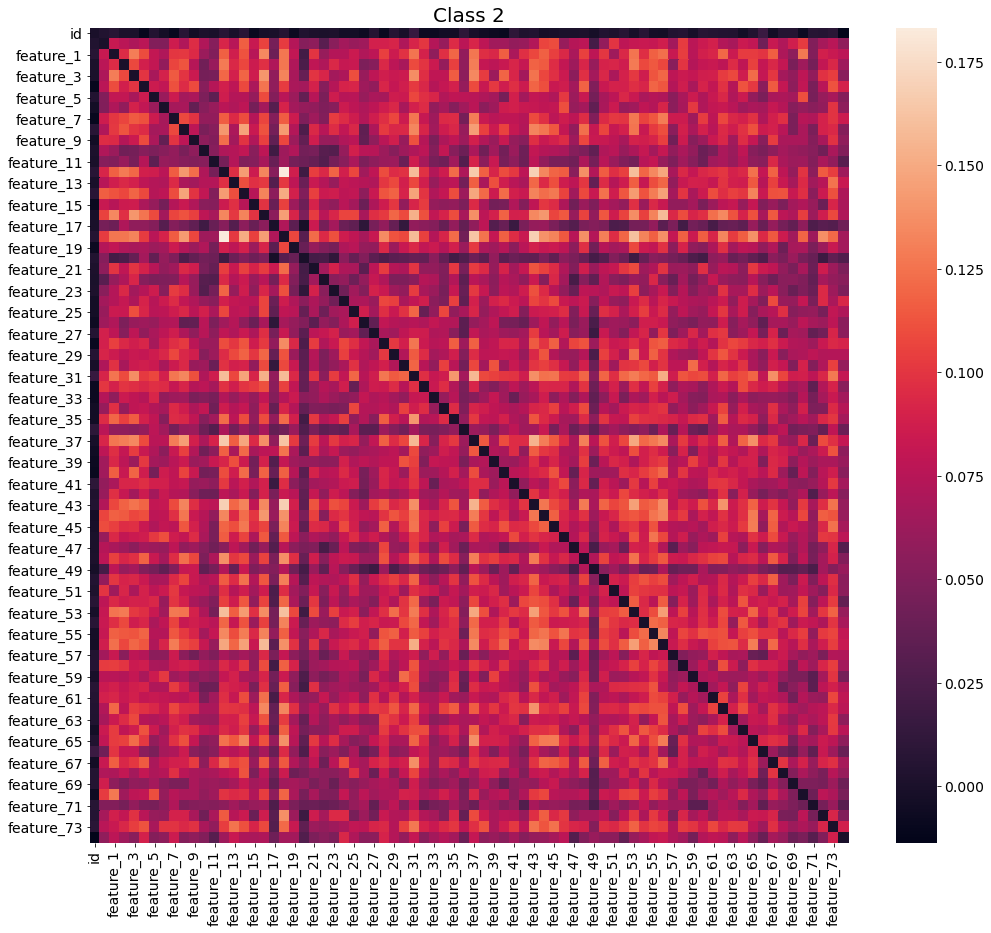

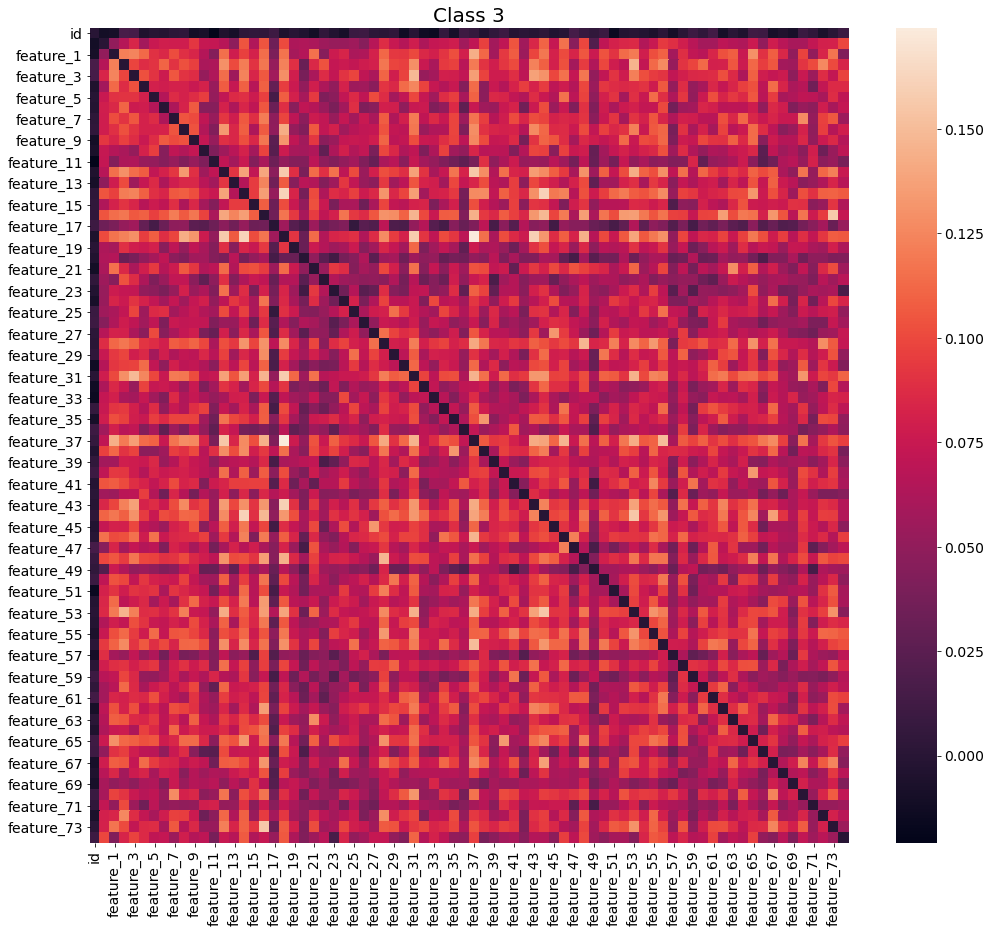

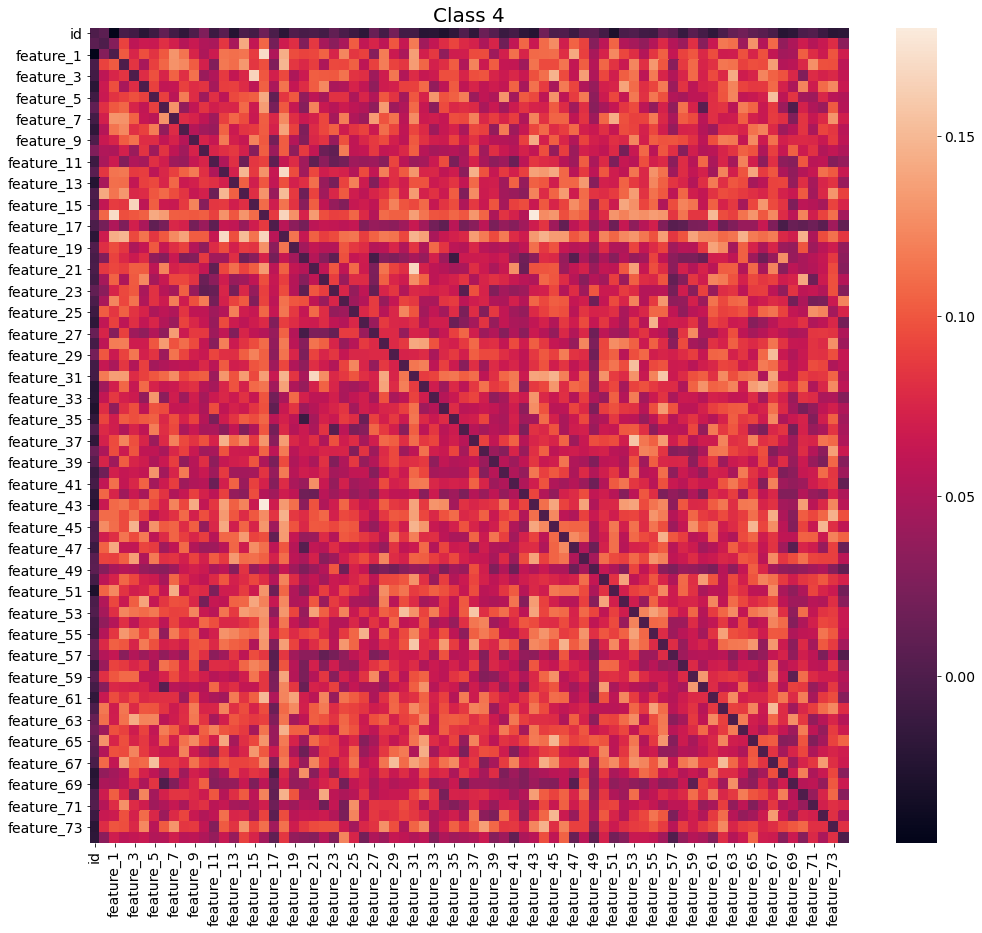

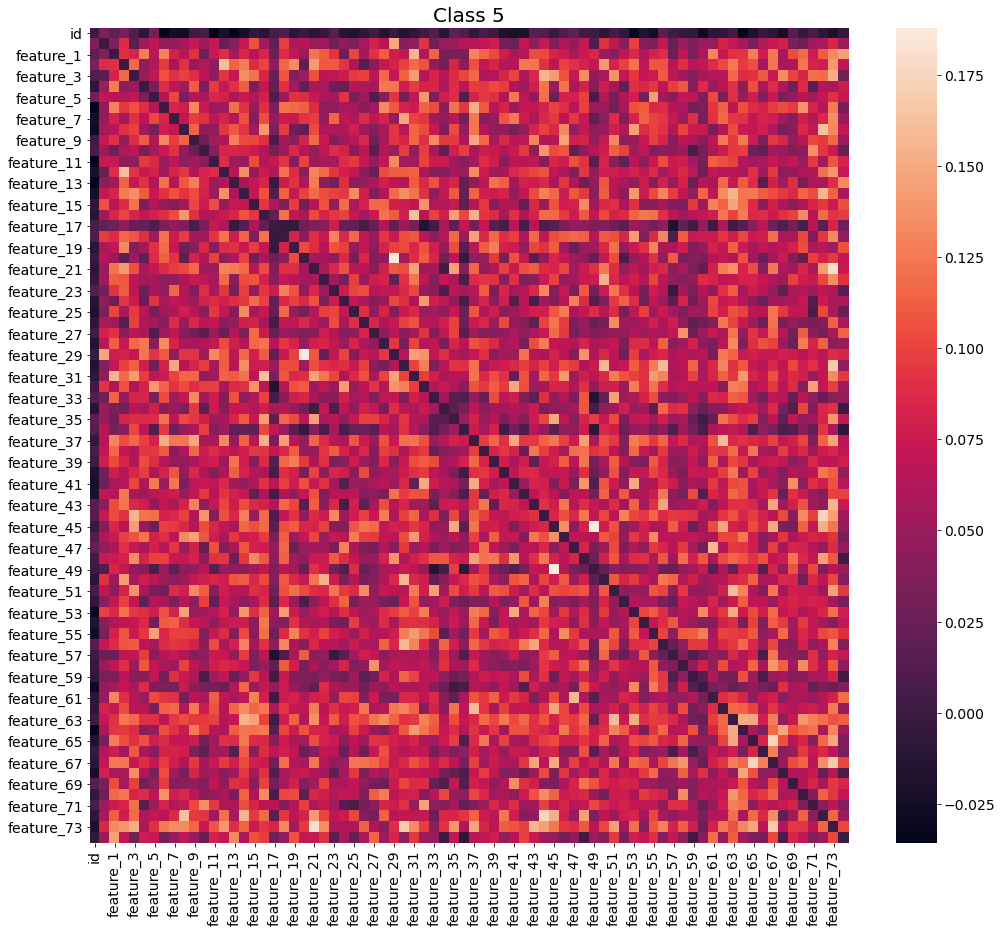

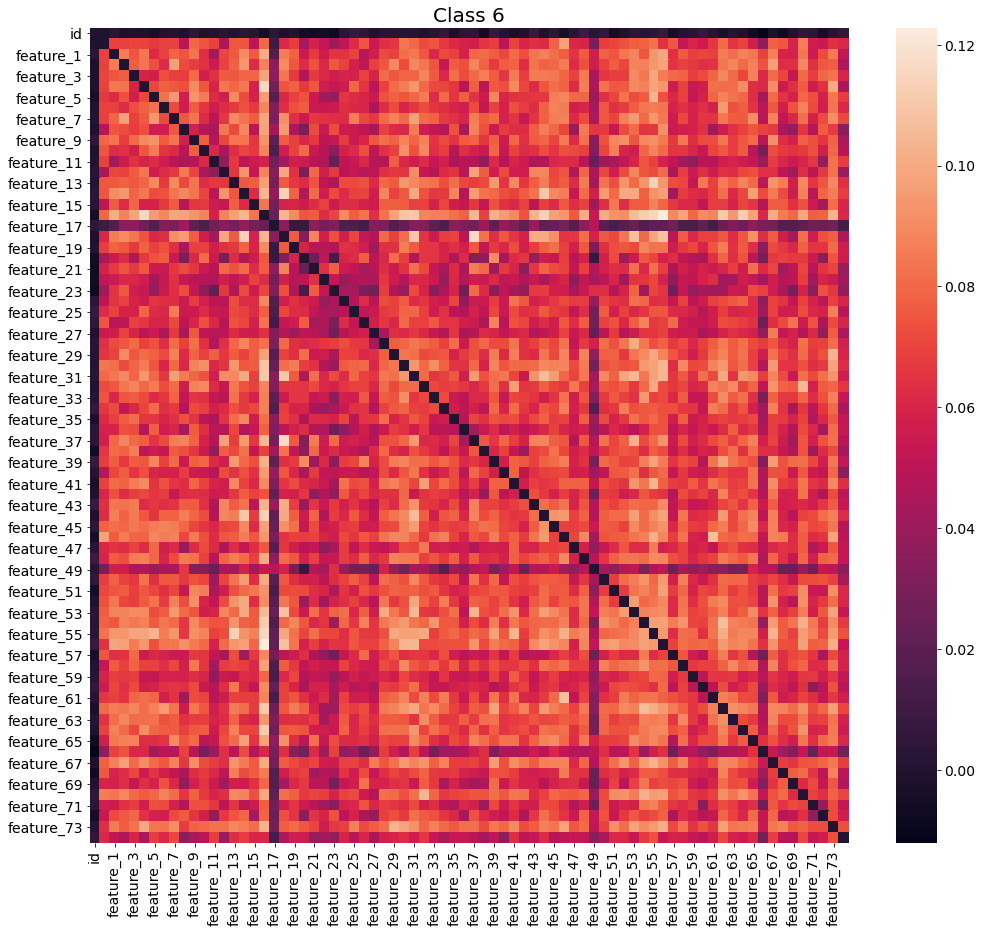

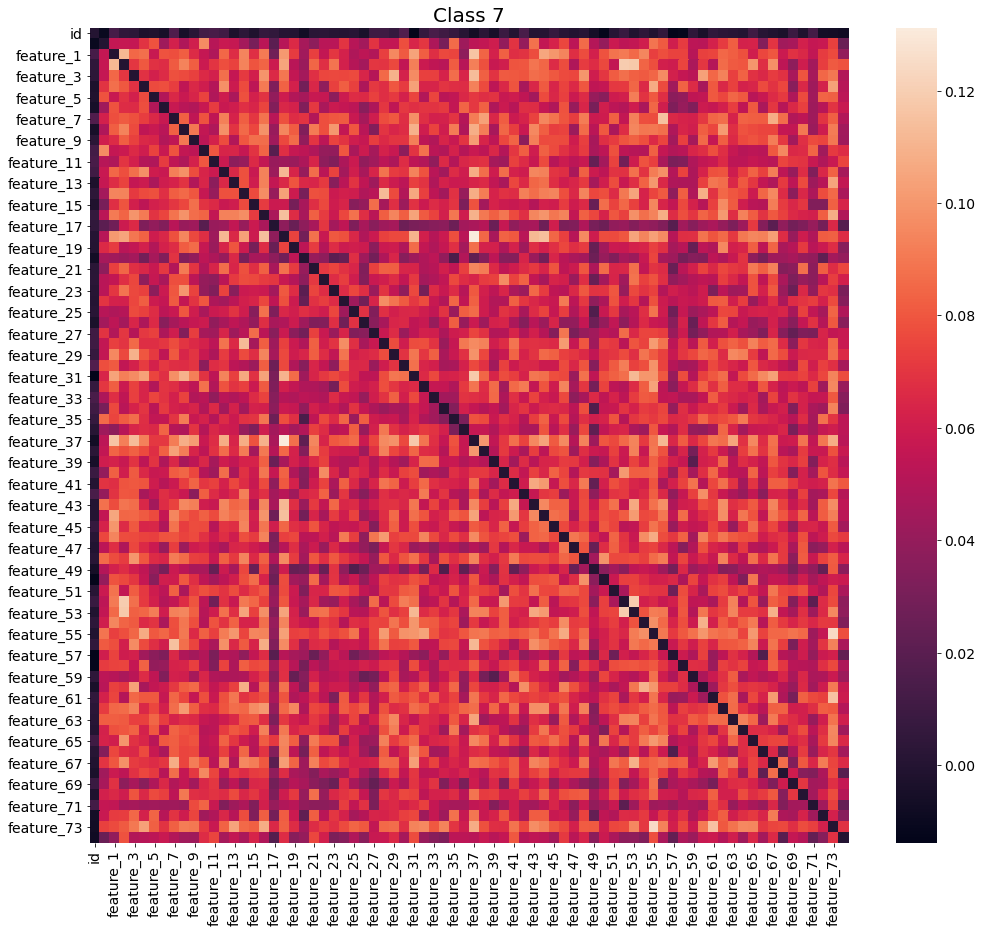

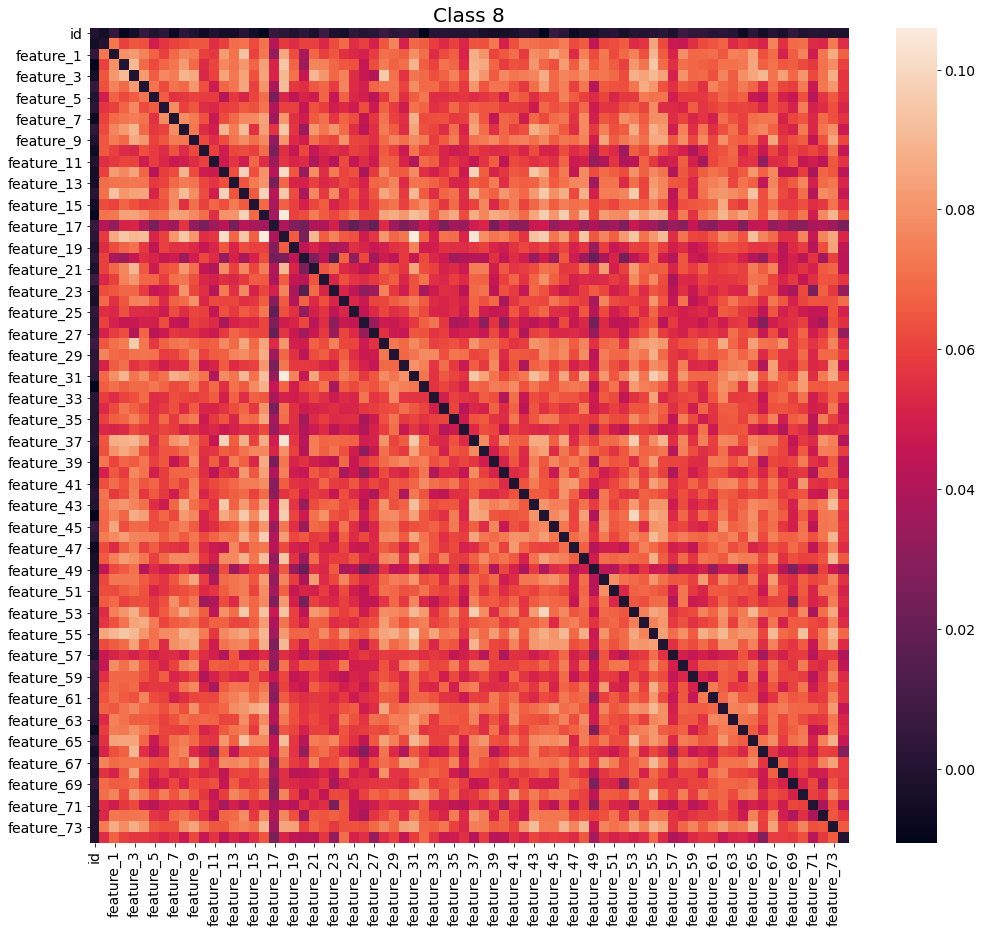

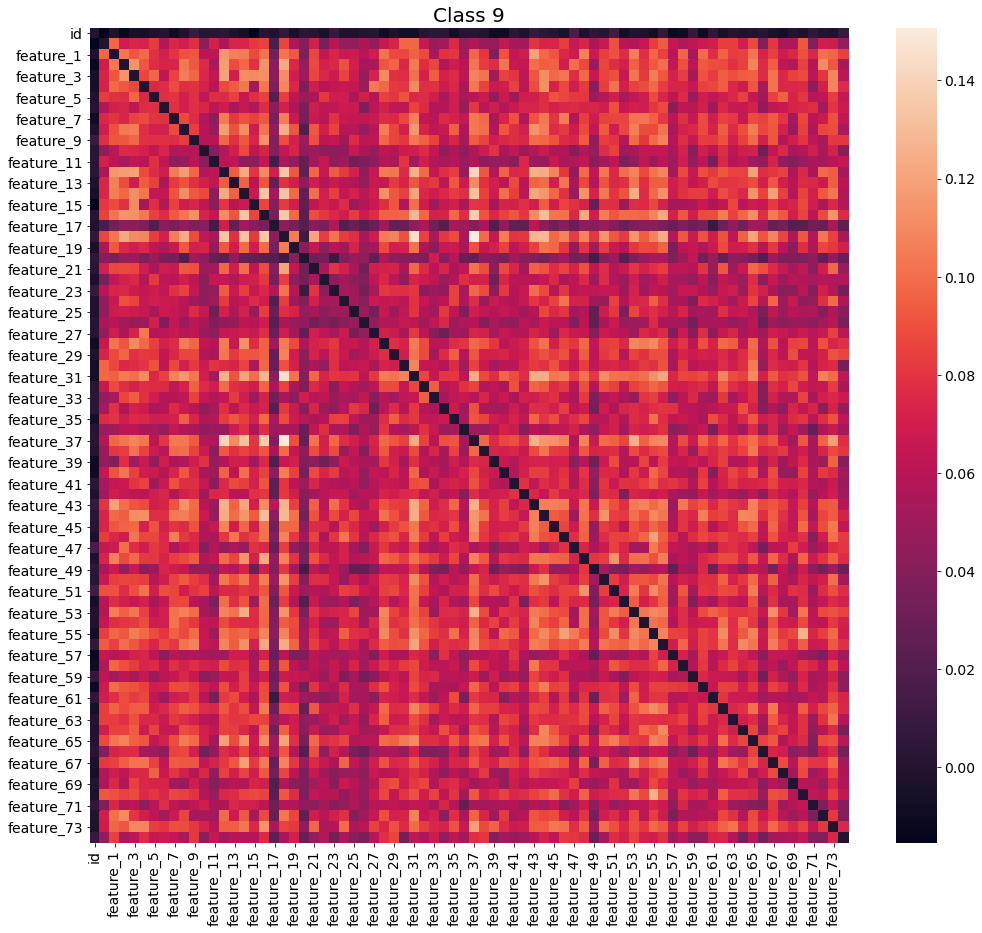

In [19]:
for i in range(1, df['target'].nunique()+1):
    sub_df = df.loc[df['target'] == i].copy()
    sub_df.drop('target', axis=1, inplace=True)
    corr = sub_df.corr()
    np.fill_diagonal(corr.values, 0.)
    fig, ax = plt.subplots(figsize=(17, 15))
    sns.heatmap(corr)
    ax.set_title('Class %d' % i)
    plt.show()

### Train test split + Standard Scaling

In [16]:
X = df.iloc[:, 1:-1].values
y = df['target'].values
X.shape, y.shape

((200000, 75), (200000,))

In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0)

In [18]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

In [19]:
X_train_std.shape, X_val_std.shape

((160000, 75), (40000, 75))

In [20]:
X_train_std.min(), X_train_std.max()

(-0.7154347566628287, 56.61625243124585)

## Modelisation

In [21]:
X_train_scale = X_train_std
X_val_scale = X_val_std

For this Kaggle competition, the evalution metric is imposed: the cross-entropy loss, which is defined as

$$ \log\ \mathrm{loss} = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log (p_{ij}) $$

where $N$ is the number of products we want to predict the class they belong to, $M$ is the number of classes (9 here), $y_{ij}$ is equal to 1 if product $i$ belongs to class $j$, otherwise 0, and $p_{ij}$ is the predicted probability for product $i$ to belong to class $j$. 

In [24]:
def train_classifier(classifier, X=X_train_scale, y=y_train, X_val=X_val_scale, y_val=y_val):
    """
    Function that takes a classifier from the sklearn library
    and will train it on provided features X, and labels y.
    Returns log loss on validation data y_val.
    """
    classifier.fit(X, y)
    y_pred = classifier.predict_proba(X_val)
    print(f"Log loss: {round(log_loss(y_val, y_pred),4)}")
    return classifier

1:80: E501 line too long (93 > 79 characters)


### Dummy 

Let us first use a dummy classifier that will assign a constant probability for each class to every product.

In [30]:
clf = DummyClassifier(strategy='uniform')

In [31]:
clf = train_classifier(clf)

Log loss: 2.1972


### KNearestNeighbors

In [32]:
clf = KNeighborsClassifier(50)

In [33]:
%%time
clf = train_classifier(clf)

Log loss: 2.6859
Wall time: 18min 23s


### Logistic Regression

In [34]:
clf = LogisticRegressionCV(
    dual=False,
    random_state=0)

In [35]:
%%time
clf = train_classifier(clf)

Log loss: 1.8285
Wall time: 46.2 s


### Support Vector Machine

In [36]:
clf = SVC(
    kernel='linear',
    probability=True, 
    max_iter=200,
    random_state=0)

In [37]:
%%time
clf = train_classifier(clf)

C:\Users\Ludo\Anaconda3\envs\oc-p8-env\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Log loss: 1.9971
Wall time: 6min 12s


Let us try with the kernel trick:

In [38]:
clf = SVC(
    kernel='rbf',
    probability=True,
    max_iter=200,
    random_state=0)

In [39]:
%%time
clf = train_classifier(clf)

C:\Users\Ludo\Anaconda3\envs\oc-p8-env\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Log loss: 2.0023
Wall time: 8min 11s


### Random Forest

In [40]:
clf = RandomForestClassifier(
    n_estimators=100,
    random_state=0)

In [41]:
%%time
clf = train_classifier(clf)

Log loss: 2.0338
Wall time: 44.6 s


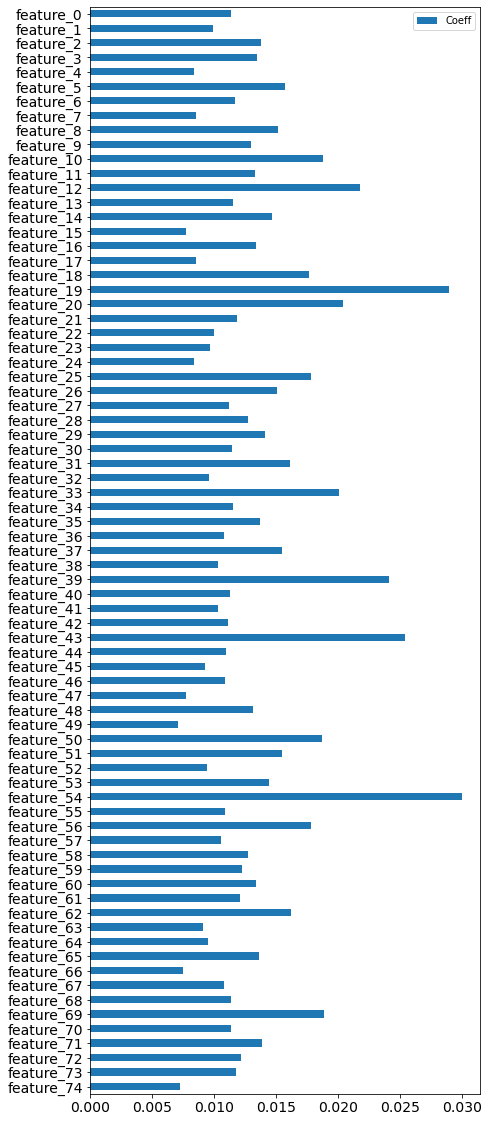

In [42]:
feat = clf.feature_importances_
feat_df = pd.DataFrame(
    {'Coeff': feat},
    index=df.columns[1:-1])
ax = feat_df.plot.barh(figsize=(7,20))
ax.invert_yaxis()
plt.show()

### Gradient Boosting

In [82]:
clf = GradientBoostingClassifier(
    n_estimators=100,
    random_state=0)

In [83]:
%%time
clf = train_classifier(clf)

Log loss: 1.7543
Wall time: 12min 35s


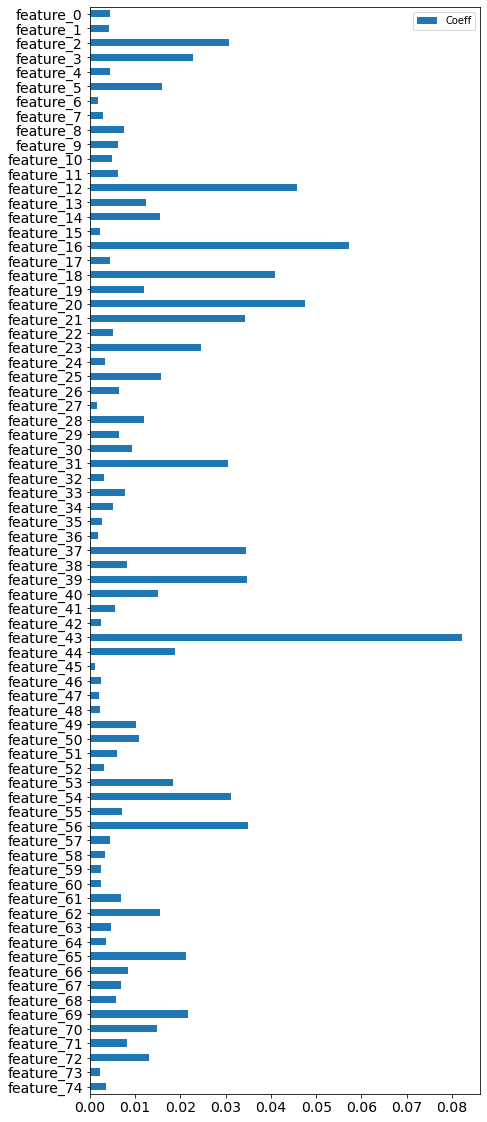

In [84]:
feat = clf.feature_importances_
feat_df = pd.DataFrame(
    {'Coeff': feat},
    index=df.columns[1:-1])
ax = feat_df.plot.barh(figsize=(7,20))
ax.invert_yaxis()
plt.show()

#### Feature Selection

In [85]:
gb_feat = SelectFromModel(
    clf,
    prefit=True, 
    threshold=0.01) 
X_train_select = gb_feat.transform(X_train_scale)
X_test_select = gb_feat.transform(X_val_scale)
X_train_select.shape

(160000, 30)

In [87]:
gb_feat_select = GradientBoostingClassifier(
    **gb_feat.estimator.get_params())

In [89]:
%%time
gb_feat_select = train_classifier(gb_feat_select)

Log loss: 1.7543
Wall time: 12min 42s


With feature selection, keeping only 30 features, we manage to obtain the same performance as previously!!!

#### Fine Tuning

In [46]:
%%time
model = GradientBoostingClassifier(
    random_state=0) 
# define parameters to try
n_estimators = [90, 100, 110] 
learning_rates = [0.1]
losses = ['deviance'] 
max_depths = [3, 4] 
min_samples_leaf = [3]
min_samples_split = [2]
max_features = ['auto']
param_grid = {'n_estimators': n_estimators, 
              'max_depth': max_depths, 
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split, 
              'max_features':max_features, 
              'loss': losses,
              'learning_rate': learning_rates}
gb_gs = GridSearchCV(
    model,
    param_grid,
    scoring='neg_log_loss',
    cv=3,
    n_jobs=4,
    verbose=3)
gb_gs.fit(X_train_scale,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed: 64.2min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed: 64.2min finished


Wall time: 1h 16min 55s


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=4,
             param_grid={'learning_rate': [0.1], 'loss': ['deviance'],
                         'max_depth': [3, 4], 'max_features': ['auto'],
                         'min_samples_leaf': [3], 'min_samples_split': [2],
                         'n_estimators': [90, 100, 110]},
             scoring='neg_log_loss', verbose=3)

In [47]:
gb_gs.best_params_

{'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [48]:
gb_gs.best_score_

-1.7542787818670016

In [52]:
# saving of model
pickle.dump(
    gb_gs.best_estimator_,
    open('TPS_June2021_GradientBoosting.pkl', 'wb'))

### Submission

Here, we will create a submision for the Tabular Playground Series of June 2021 using the model with the best performance.

In [5]:
df_test = pd.read_csv('test.csv')
print(df_test.shape)
df_test.head()

(100000, 76)


,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
0,200000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,200001,1,2,0,0,0,0,0,0,0,...,3,1,3,0,0,0,0,3,0,0
2,200002,0,1,7,1,0,0,0,0,6,...,3,0,0,0,0,3,0,2,0,0
3,200003,0,0,0,4,3,1,0,0,0,...,0,0,0,1,0,0,0,4,0,0
4,200004,0,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [25]:
X_test = df_test.iloc[:, 1:].values
X_test_scale = scaler.transform(X_test)

In [72]:
test_pred = xgb_gs.best_estimator_.predict_proba(
    X_test_scale)

In [26]:
test_pred = model.predict_proba(X_test_scale)

In [28]:
# saving the results
res = pd.DataFrame()
res['id'] = df_test['id']
res[['Class_' + str(i) for i in range(1, 10)]] = test_pred
res.to_csv('submission_GradientBoosting.csv', index=False)

In [29]:
res.head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.046079,0.340814,0.168695,0.024729,0.013042,0.186038,0.028646,0.072492,0.119465
1,200001,0.043224,0.112412,0.070257,0.019308,0.012569,0.239914,0.073375,0.296288,0.132652
2,200002,0.032235,0.039845,0.026337,0.013186,0.009020,0.632007,0.033106,0.140283,0.073982
3,200003,0.061329,0.106349,0.087358,0.041735,0.015930,0.225402,0.069388,0.203804,0.188704
4,200004,0.043176,0.117266,0.077857,0.032895,0.016058,0.302164,0.060386,0.203566,0.146632


In [30]:
classes = np.argmax(test_pred, axis=1)
df_test['target'] = classes.tolist()
df_test.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
0,200000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,200001,1,2,0,0,0,0,0,0,0,0,1,0,2,2,0,0,1,0,0,0,2,0,0,1,0,3,0,1,0,0,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,3,2,0,0,0,0,0,0,1,7,0,1,3,1,3,0,0,0,0,3,0,0,7
2,200002,0,1,7,1,0,0,0,0,6,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,2,0,0,4,0,0,0,0,0,0,0,0,1,0,0,4,0,0,1,0,0,0,6,0,0,2,10,0,0,0,2,1,0,0,0,0,0,3,0,0,0,0,3,0,2,0,0,5
3,200003,0,0,0,4,3,1,0,0,0,0,7,0,0,0,7,0,0,0,5,0,1,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,7,5,0,0,0,0,0,0,0,0,0,2,3,0,0,0,1,0,0,0,0,0,4,0,0,0,1,0,0,0,4,0,0,5
4,200004,0,0,5,0,0,0,0,0,0,8,1,0,2,0,0,0,0,0,9,1,0,0,0,0,0,0,0,0,3,0,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,2,1,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,5


In [31]:
y_values_train = df['target'].value_counts(
    normalize=True)
y_values_test = df_test['target'].value_counts(
    normalize=True)
x, y_test, y_train = np.arange(9), np.zeros(9), np.zeros(9)
y_test[y_values_test.index] = y_values_test.values
y_train[y_values_train.index-1] = y_values_train.values

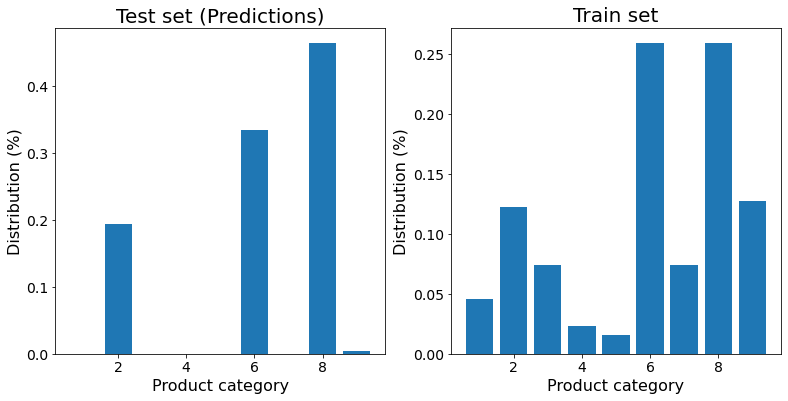

In [32]:
# display predicted and train classes distribution
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
# first plot
ax[0].bar(x+1, y_test)
ax[0].set_title('Test set (Predictions)')
ax[0].set_xlabel('Product category')
ax[0].set_ylabel('Distribution (%)')
# second plot
ax[1].bar(x+1, y_train)
ax[1].set_title('Train set')
ax[1].set_xlabel('Product category')
ax[1].set_ylabel('Distribution (%)')
plt.show()